# Chainlink Data Feed

In [1]:
# Import necessary libraries
from ethereum import *
import gzip
import os

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pickle

# Import the necessary libraries for plotting
# from utils_plot import *

pd.set_option('display.precision', 18)
tqdm.pandas()


In [2]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [3]:
dataset_dir = './dataset/'
plots_dir = './plots/'
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)


## Data Gathering

In [4]:
# Loading necessary variables
etherscan_api_key = os.environ["ETHERSCAN_API_KEY"]
eth_node = os.environ["ETHEREUM_NODE_URL"]


In [5]:
# Import Web3 library and stablish connection to Ethereum node
from web3 import Web3
w3 = Web3(Web3.HTTPProvider(eth_node))
# w3.isConnected()
print("The most recent block number in the node's chain is", w3.eth.blockNumber)
# w3.net.listening


The most recent block number in the node's chain is 16368388


In [6]:
# The Chainlink COMP/USD Price Feed was created in block number 10,705,616 at transaction 0x99093a3ff37ce45b4b3f5bebf42405161dffe0ad56ce82d7807a46974dbeed03
# https://etherscan.io/tx/0x99093a3ff37ce45b4b3f5bebf42405161dffe0ad56ce82d7807a46974dbeed03
# The Chainlink COMP/USD controller was created in block number 123,815,72  at transaction 0xaa7a3641960fcd1f582e63b80ee330e57f3c4a055d22bded2c8c381139377295
# https://etherscan.io/tx/0xaa7a3641960fcd1f582e63b80ee330e57f3c4a055d22bded2c8c381139377295
block_number_min, block_number_max = 12381572, w3.eth.block_number
print(block_number_min, block_number_max)


12381572 16368388


In [7]:
# Define the Chainlink COMP/USD contract address
chainlink_contract_address = '0xdbd020CAeF83eFd542f4De03e3cF0C28A4428bd5'
chainlink_aggregator_address = '0x6eaC850f531d0588c0114f1E93F843B78669E6d2'
# 0x68a371D12213a1EbDd5fa9a2EE5519E6B73F1E37
chainlink_price_updated_topic = '0x0559884fd3a460db3073b7fc896cc77986f16e378210ded43186175bf646fc5f'
# Get contract object
chainlink_contract = get_contract(
    w3, contract_address=chainlink_aggregator_address, etherscan_api_key=etherscan_api_key)


In [8]:
# Get the events available in the Chainlink (COMP/USD) data feed contract
# If you only need the COMP/USD prices then you can gather only the AnswerUpdated event.
for event in chainlink_contract.events:
    print(event.event_name)


AddedAccess
AnswerUpdated
BillingAccessControllerSet
BillingSet
CheckAccessDisabled
CheckAccessEnabled
ConfigSet
NewRound
NewTransmission
OraclePaid
OwnershipTransferRequested
OwnershipTransferred
PayeeshipTransferRequested
PayeeshipTransferred
RemovedAccess
RequesterAccessControllerSet
RoundRequested
ValidatorConfigSet


In [9]:
chainlink_events = get_all_events_from_contract(
    contract=chainlink_contract, start_block=block_number_min, end_block=block_number_max, max_workers=25)


AddedAccess


AddedAccess:   0%|          | 0/798 [00:00<?, ?it/s]

AnswerUpdated


AnswerUpdated:   0%|          | 0/798 [00:00<?, ?it/s]

BillingAccessControllerSet


BillingAccessControllerSet:   0%|          | 0/798 [00:00<?, ?it/s]

BillingSet


BillingSet:   0%|          | 0/798 [00:00<?, ?it/s]

CheckAccessDisabled


CheckAccessDisabled:   0%|          | 0/798 [00:00<?, ?it/s]

CheckAccessEnabled


CheckAccessEnabled:   0%|          | 0/798 [00:00<?, ?it/s]

ConfigSet


ConfigSet:   0%|          | 0/798 [00:00<?, ?it/s]

NewRound


NewRound:   0%|          | 0/798 [00:00<?, ?it/s]

NewTransmission


NewTransmission:   0%|          | 0/798 [00:00<?, ?it/s]

OraclePaid


OraclePaid:   0%|          | 0/798 [00:00<?, ?it/s]

OwnershipTransferRequested


OwnershipTransferRequested:   0%|          | 0/798 [00:00<?, ?it/s]

OwnershipTransferred


OwnershipTransferred:   0%|          | 0/798 [00:00<?, ?it/s]

PayeeshipTransferRequested


PayeeshipTransferRequested:   0%|          | 0/798 [00:00<?, ?it/s]

PayeeshipTransferred


PayeeshipTransferred:   0%|          | 0/798 [00:00<?, ?it/s]

RemovedAccess


RemovedAccess:   0%|          | 0/798 [00:00<?, ?it/s]

RequesterAccessControllerSet


RequesterAccessControllerSet:   0%|          | 0/798 [00:00<?, ?it/s]

RoundRequested


RoundRequested:   0%|          | 0/798 [00:00<?, ?it/s]

ValidatorConfigSet


ValidatorConfigSet:   0%|          | 0/798 [00:00<?, ?it/s]

In [17]:
with gzip.open(dataset_dir+'chainlink_comp_to_usd_events.pickle.gz', 'wb') as file:
    pickle.dump(chainlink_events, file)


## Chainlink data feed for COMP to USD

In [18]:
with gzip.open(dataset_dir+'chainlink_comp_to_usd_events.pickle.gz', 'rb') as file:
    chainlink_events = pickle.load(file)


In [19]:
def parse_common_attributes(event):
    data = dict()
    data['blockNumber'] = event['blockNumber']
    data['transactionHash'] = event['transactionHash'].hex().lower()
    data['blockHash'] = event['blockHash'].hex().lower()
    data['address'] = event['address'].lower()
    data['transactionIndex'] = event['transactionIndex']
    data['logIndex'] = event['logIndex']
    data['event'] = event['event']
    return data


def answer_updated_to_dataframe(events):
    # Convert AnswerUpdated events data to dataframe
    df = list()
    for event in tqdm(events, desc='Loading AnswerUpdated events'):
        data = parse_common_attributes(event)

        data['current'] = event['args']['current'] / 1e8
        data['roundId'] = event['args']['roundId']
        data['updatedAt'] = pd.to_datetime(
            event['args']['updatedAt'], unit='s')
        df.append(data)
    return pd.DataFrame(df)


In [20]:
def plot_ohlc(series, title=''):
    fig = go.Figure(data=go.Candlestick(x=series.index,
                    open=series['open'],
                    high=series['high'],
                    low=series['low'],
                    close=series['close']))
    fig.update_layout(autosize=True, title=title)
    fig.update_layout(yaxis_title='Prices USD',
                      xaxis_rangeslider_visible=False, template='plotly_white')
    return fig


In [21]:
for event_name in chainlink_events:
    print(
        f"There are {len(chainlink_events[event_name])} {event_name} events")


There are 2 AddedAccess events
There are 21084 AnswerUpdated events
There are 1 BillingAccessControllerSet events
There are 86 BillingSet events
There are 0 CheckAccessDisabled events
There are 0 CheckAccessEnabled events
There are 5 ConfigSet events
There are 21084 NewRound events
There are 21084 NewTransmission events
There are 1558 OraclePaid events
There are 1 OwnershipTransferRequested events
There are 1 OwnershipTransferred events
There are 1 PayeeshipTransferRequested events
There are 22 PayeeshipTransferred events
There are 0 RemovedAccess events
There are 1 RequesterAccessControllerSet events
There are 0 RoundRequested events
There are 2 ValidatorConfigSet events


In [22]:
chainlink_price_df = answer_updated_to_dataframe(
    chainlink_events['AnswerUpdated'])
print(
    f"There are {chainlink_price_df.shape[0]} AnswerUpdated events")
chainlink_price_df.head()


Loading AnswerUpdated events:   0%|          | 0/21084 [00:00<?, ?it/s]

There are 21084 AnswerUpdated events


,blockNumber,transactionHash,blockHash,address,transactionIndex,logIndex,event,current,roundId,updatedAt
0,12419231,0x0a082e399f10fcd6d47deda398c5aa22162eaed3aa51...,0xf21ee951c7ad95a01b70a7cac47d473633db47785871...,0x6eac850f531d0588c0114f1e93f843b78669e6d2,218,153,AnswerUpdated,836.798851639999952567,1,2021-05-12 11:02:54
1,12419238,0xc9d45a113bddc1f1aed347724af4a494d748d9863278...,0x59803088c87940b78eea238e86478fd50c3bdce7530c...,0x6eac850f531d0588c0114f1e93f843b78669e6d2,165,307,AnswerUpdated,836.798851639999952567,2,2021-05-12 11:05:04
2,12419325,0xf8d34023ca01a20514e28256eca68d2ede5de535e5b4...,0xa1c28ca6893edd3caf6c03db2214d97b1340bcd51cea...,0x6eac850f531d0588c0114f1e93f843b78669e6d2,169,100,AnswerUpdated,845.341357389999984662,3,2021-05-12 11:23:20
3,12419646,0x13cfa4888c84c9d39e537b5bea497221c42a836db10b...,0x9eee25a9f9d978f9f52c07f8ebdde0ac90794fd7551e...,0x6eac850f531d0588c0114f1e93f843b78669e6d2,141,118,AnswerUpdated,835.483673990000056619,4,2021-05-12 12:37:29
4,12419840,0x12828b6698a649ff14b300f05d57bcc6d81979d371c4...,0xbb99fb5a0c8648ef11a18d85ff713888797a2cced246...,0x6eac850f531d0588c0114f1e93f843b78669e6d2,30,46,AnswerUpdated,826.485379999999963729,5,2021-05-12 13:26:18


In [23]:
window = '1W'
data = chainlink_price_df.set_index('updatedAt').current
data.resample(window)
sma = data.rolling(min_periods=1, window=7,
                   center=False).mean().resample('2D').last()
fig = plot_ohlc(data.resample(window).ohlc(),
                title='Chainlink price for COMP / USD')
fig.add_trace(go.Scatter(x=sma.index, y=sma, mode='lines', name='Price'))
fig.show()


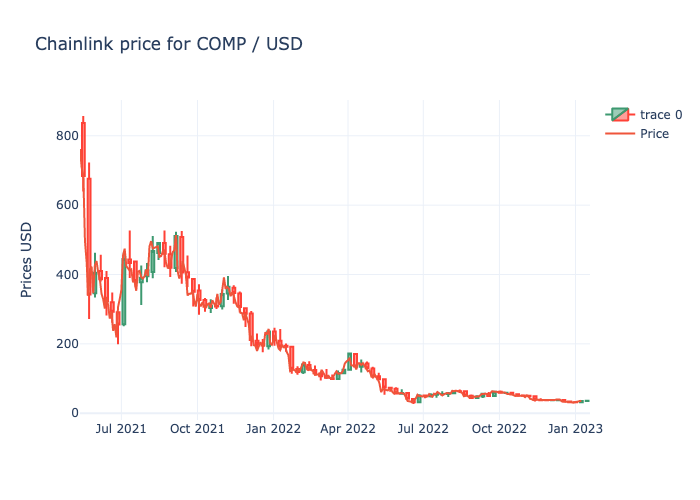

In [27]:
window = '1W'
data = chainlink_price_df.set_index('updatedAt').current
data.resample(window)
sma = data.rolling(min_periods=1, window=7,
                   center=False).mean().resample('2D').last()
fig = plot_ohlc(data.resample(window).ohlc(),
                title='Chainlink price for COMP / USD')
fig.add_trace(go.Scatter(x=sma.index, y=sma, mode='lines', name='Price'))
fig.show('png')


In [28]:
percentiles = [.01, .05, .1, .2, .25, .50, .75, .8, .9, .95, .99]


In [29]:
chainlink_price_df['current'].describe(percentiles=percentiles)


count    21084.000000000000000000
mean       202.242558082706295863
std        163.958530003805577735
min         26.618048600000001613
1%          31.303863946900001736
5%          36.342143799500000512
10%         40.092639979000004757
20%         51.743435196000000076
25%         55.913651817499996355
50%        135.070844954999984111
75%        335.480180010000026414
80%        370.861657764000028692
90%        427.084256659999994099
95%        473.833241983999982949
99%        692.356327091599496271
max        857.035787400000003800
Name: current, dtype: float64